**Stock price forcasting with LSTM**

This is my project to forcast close price of stock market based on LSTM.
I use yahoo api for getting stock data and develop forcasting model based on Keras on Python 3.
The result of this model isn't good enougth but this is the case study about how to use deep learning to analyze time series data.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pandas_datareader import data
from datetime import datetime

%matplotlib inline

In [0]:
# Define the Stock and number of days for sliced windows.
stock_name = 'AAPL'
day = 90

start_date = datetime(2010, 1, 1)
end_date = datetime(2019, 2, 28)

date_for_split_train_test = datetime(2018, 12, 31)

###################################################

In [21]:
stock = data.DataReader(stock_name, 'yahoo', start_date, end_date)
stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,20.386072
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,20.421322
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,20.096491
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,20.059338
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,20.192701


In [0]:
# Preprocess data
stock = data.DataReader(stock_name, 'yahoo', start_date, end_date)

training_set = stock.reset_index()
training_set = training_set[training_set['Date'] <= date_for_split_train_test][['Date', 'Close']]

test_set = stock.reset_index()
test_set = test_set[test_set['Date'] > date_for_split_train_test][['Date', 'Close']]

test_set = test_set.reset_index()
test_set = test_set.drop(columns=['index'])

In [0]:
def feature_generate(data, day):
  feature = []

  for i in range(0, data.shape[0] - day):
    temp = data['Close'][i:i+day].values
    feature.append(temp)

  feature = np.asarray(feature)
  feature = np.reshape(feature, (feature.shape[0], feature.shape[1], 1))
  
  return feature

def target_generate(data, day):
  target = []

  for i in range(day, data.shape[0]):
    temp = data['Close'][i]
    target.append(temp)

  target = np.asarray(target)
  target = np.reshape(target, (target.shape[0], 1))
  
  return target

def test_generate(data, day):
  test = []
  
  for i in range(data.shape[0] - day, data.shape[0]):
    temp = data['Close'][i]
    test.append(temp)
    
  test = np.asarray(test)
  test = np.reshape(test, (test.shape[0], 1))
  
  return test  

In [24]:
x_train = feature_generate(training_set, day)
y_train = target_generate(training_set, day)

x_test = test_generate(training_set, day)
x_test_temp = np.reshape(x_test, (1, day, 1))

y_test = test_set['Close']

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2174, 90, 1)
(2174, 1)
(90, 1)
(40,)


In [25]:
# Develop model with LSTM.
model = keras.Sequential()

model.add(keras.layers.CuDNNLSTM(units=day*2, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.CuDNNLSTM(units=day*4, return_sequences=True))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.CuDNNLSTM(units=day*4, return_sequences=True))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.CuDNNLSTM(units=day*2))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
2174/2174 [==============================] - 11s 5ms/sample - loss: 8940.2010
Epoch 2/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 6982.4143
Epoch 3/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 5588.5658
Epoch 4/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 4544.5170
Epoch 5/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 3775.6717
Epoch 6/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 3204.0129
Epoch 7/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 2793.9757
Epoch 8/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 2517.5593
Epoch 9/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 2336.1439
Epoch 10/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 2230.1812
Epoch 11/100
2174/2174 [==============================] - 8s 4ms/sample - loss: 2164.2571
Epoch 12/100
2174/

In [26]:
model.evaluate(x_train, y_train)

2174/2174 [==============================] - 3s 2ms/sample - loss: 15.1254


15.125399879939861

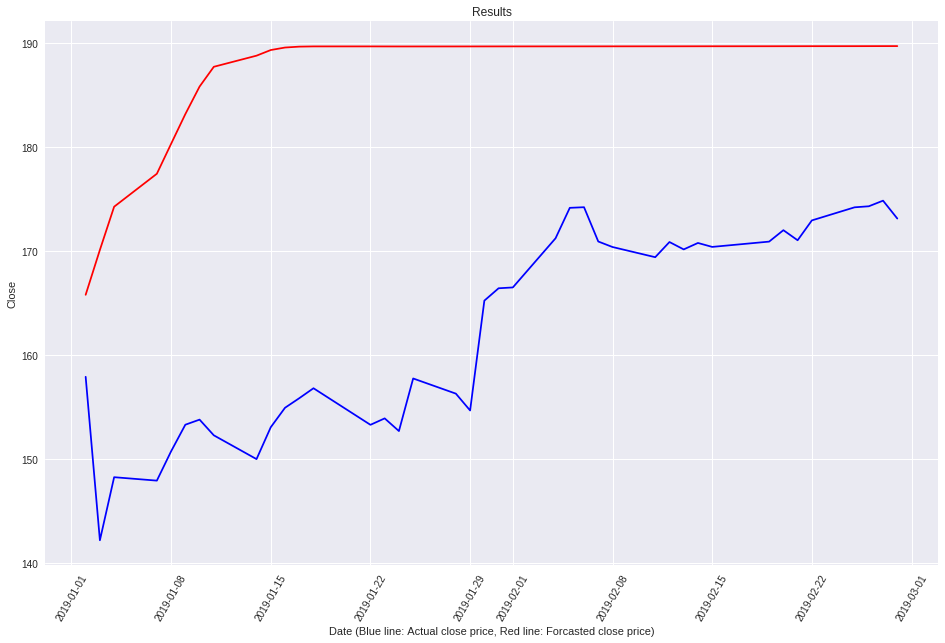

In [28]:
# Plot the result
y_pred = []
x_test_copy = x_test

for i in range(0, y_test.shape[0]):
  x_test_temp = np.reshape(x_test_copy, (1, day, 1))
  temp = model.predict(x_test_temp)
  y_pred.append(temp[0][0])
  
  x_test_copy = np.append(x_test_copy, temp)[1:day+1]
  
y_pred = np.asarray(y_pred)
test_set['Forcasted'] = pd.DataFrame(y_pred, columns=['Forcasted'])

plt.figure(figsize=(16,10))
plt.title('Results')
plt.xlabel("Date (Blue line: Actual close price, Red line: Forcasted close price)")
plt.ylabel('Close')
plt.plot(test_set['Date'], test_set['Close'], 'b')
plt.plot(test_set['Date'], test_set['Forcasted'], 'r')
plt.xticks(rotation=60)
plt.show()

test_set = test_set.drop(columns=['Forcasted'])